In [65]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crop-and-fertilizer-dataset-for-westernmaharashtra:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3431577%2F5987682%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T134745Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6fcb75f1c80c934b89c1ef54e48c54f77e51c8064009998179a837cb5665051d7395a44bb589d22a311c69d41a0dcaa73d5a95ea44ad225615196d012e8211a1c0b17e28f3e3896c57add647c41da78785b769762718da7f9eae228ebc6ac82f137d1473d7e8826b009e851b2dcb5c9d88c8948773cb9012e715728e4842cca160b37f5889bdeae6d39be43bc55e300ae9771b5403b830a4985ef64519207dbfddade93214035da72a02bd02daa6dc1f8adf783a2f9eca68b845e9f2a5e4af091cacb8af86bd731cbcbd86bbf4470ebde95db4cd5601d6c0a056651a325d605f0ad6c5c76795dd492f1beacda428ca77989f9f9950c7a4adc0f1887ac374fb3a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20051 bytes downloaded
Downloaded and uncompressed: crop-and-fertilizer-dataset-for-westernmaharashtra
Data source import complete.


# Imoprting dependcies of Kaggle

In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: :https//github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-and-fertilizer-dataset-for-westernmaharashtra/Crop and fertilizer dataset.csv


# **So this notebook consiste of 2 aspects**

1. complete Machine Learning Model (required)
2. systemizing the model (building a system out of it) #setting prediction functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# **Reading The Data**

In [68]:
dataset = pd.read_csv('/kaggle/input/crop-and-fertilizer-dataset-for-westernmaharashtra/Crop and fertilizer dataset.csv')
dataset.head(4)

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link
0,Kolhapur,Black,75,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
1,Kolhapur,Black,80,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
2,Kolhapur,Black,85,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
3,Kolhapur,Black,90,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo


# > **Exploratory Data Analysis **
it's about get to know more about our data

1. check null values and duplicated
2. Distributions

In [69]:
dataset.shape

(4513, 11)

In [70]:
dataset.Crop.value_counts()

Sugarcane    1010
Wheat         859
Cotton        650
Jowar         394
Maize         350
Rice          309
Groundnut     177
Tur           126
Ginger        125
Grapes        125
Urad           99
Moong          99
Gram           78
Turmeric       55
Soybean        45
Masoor         12
Name: Crop, dtype: int64

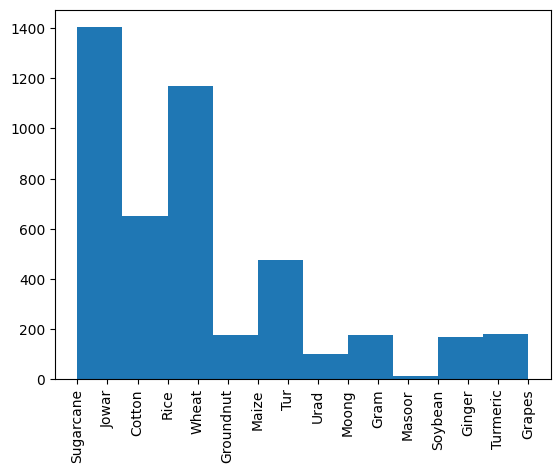

In [71]:
plt.hist(dataset['Crop'])
plt.xticks(rotation=90)
plt.show()

In [72]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District_Name  4513 non-null   object 
 1   Soil_color     4513 non-null   object 
 2   Nitrogen       4513 non-null   int64  
 3   Phosphorus     4513 non-null   int64  
 4   Potassium      4513 non-null   int64  
 5   pH             4513 non-null   float64
 6   Rainfall       4513 non-null   int64  
 7   Temperature    4513 non-null   int64  
 8   Crop           4513 non-null   object 
 9   Fertilizer     4513 non-null   object 
 10  Link           4513 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 388.0+ KB


In [73]:
object_features = [features for features in dataset.columns if dataset[features].dtype != int and dataset[features].dtype != float]

In [74]:
dataset.describe()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature
count,4513.000000,4513.000000,4513.000000,4513.000000,4513.000000,4513.000000
mean,95.409927,54.341901,63.595170,6.715267,819.189010,25.915134
std,38.060648,16.551991,35.691911,0.625198,251.730813,5.897328
min,20.000000,10.000000,5.000000,5.500000,300.000000,10.000000
25%,60.000000,40.000000,40.000000,6.000000,600.000000,20.000000
50%,105.000000,55.000000,55.000000,6.500000,800.000000,25.000000
75%,125.000000,65.000000,75.000000,7.000000,1000.000000,30.000000
max,150.000000,90.000000,150.000000,8.500000,1700.000000,40.000000


In [75]:
dataset.isnull().sum()

District_Name    0
Soil_color       0
Nitrogen         0
Phosphorus       0
Potassium        0
pH               0
Rainfall         0
Temperature      0
Crop             0
Fertilizer       0
Link             0
dtype: int64

In [76]:
dataset.duplicated().sum()

0

In [77]:
len(dataset['Crop'].unique())

16

In [78]:
import pandas as pd
duplicates = dataset[dataset.duplicated()]

if duplicates.empty:
    print("No duplicates found.")
else:
    print("Duplicates found:\n", duplicates)

No duplicates found.


In [79]:
dataset.columns.tolist()

['District_Name',
 'Soil_color',
 'Nitrogen',
 'Phosphorus',
 'Potassium',
 'pH',
 'Rainfall',
 'Temperature',
 'Crop',
 'Fertilizer',
 'Link']

In [80]:
dataset.District_Name.value_counts()

Kolhapur    1430
Satara      1000
Sangli       897
Solapur      707
Pune         479
Name: District_Name, dtype: int64

it's clear that the data is imbalanced and realivly 
small we will fixed that

In [81]:
def col_groupby(dataset, col, target):
    max_label = dataset.groupby(target)[col].max().sort_values().index[-1]
    max_val = dataset.groupby(target)[col].max().sort_values().values[-1]

    min_label = dataset.groupby(target)[col].min().sort_values().index[0]
    min_val = dataset.groupby(target)[col].min().sort_values().values[0]

    return max_label, max_val, min_label, min_val

max_label, max_val, min_label, min_val = col_groupby(dataset, 'Rainfall', 'Crop')
print(f"Max Rainfall is required for {max_label} crop of {max_val} value.")
print(f"Min Rainfall is required for {min_label} crop of {min_val} value")

max_label, max_val, min_label, min_val = col_groupby(dataset, 'Temperature', 'Crop')
print(f"Max temperature is required for {max_label} crop of {max_val} value.")
print(f"Min temperature is required for {min_label} crop of {min_val} value")

max_label, max_val, min_label, min_val = col_groupby(dataset, 'pH', 'Crop')
print(f"Max PH is required for {max_label} crop of {max_val} value.")
print(f"Min PH is required for {min_label} crop of {min_val} value")

max_label, max_val, min_label, min_val = col_groupby(dataset, 'Nitrogen', 'Crop')
print(f"Max humidity is required for {max_label} crop of {max_val} value.")
print(f"Min humidity is required for {min_label} crop of {min_val} value")


Max Rainfall is required for Turmeric crop of 1700 value.
Min Rainfall is required for Soybean crop of 300 value
Max temperature is required for Rice crop of 40 value.
Min temperature is required for Cotton crop of 10 value
Max PH is required for Sugarcane crop of 8.5 value.
Min PH is required for Ginger crop of 5.5 value
Max humidity is required for Sugarcane crop of 150 value.
Min humidity is required for Gram crop of 20 value


# **Visualization ErA  ✨**

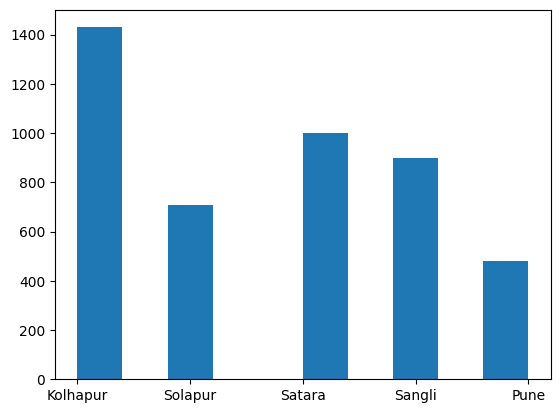

In [82]:
plt.hist(dataset['District_Name'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

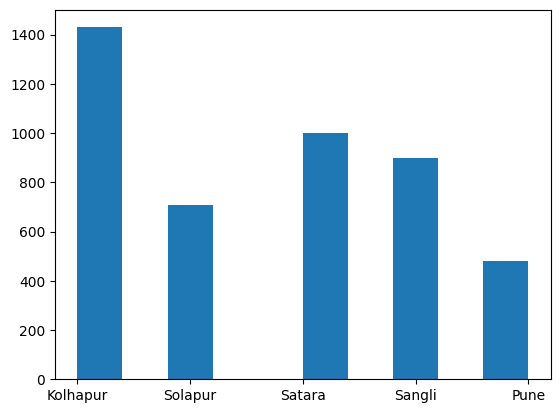

In [83]:
plt.hist(dataset['District_Name'])
plt.show

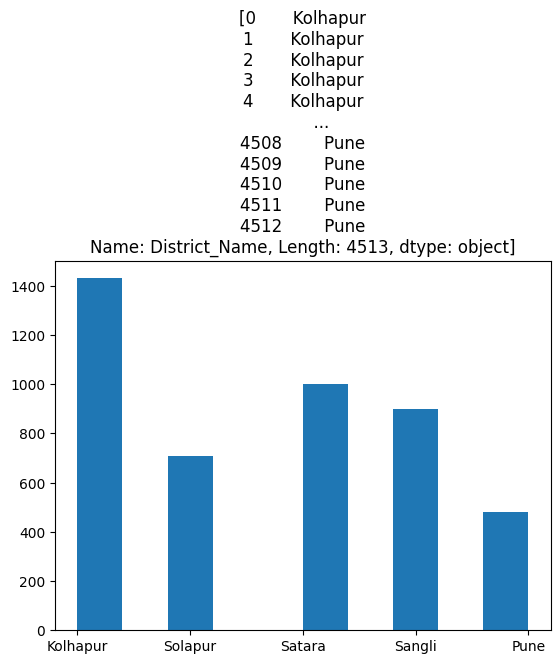

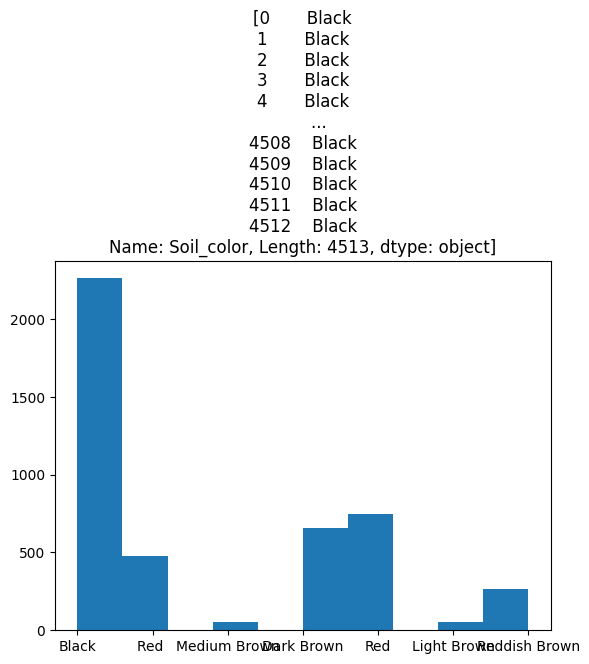

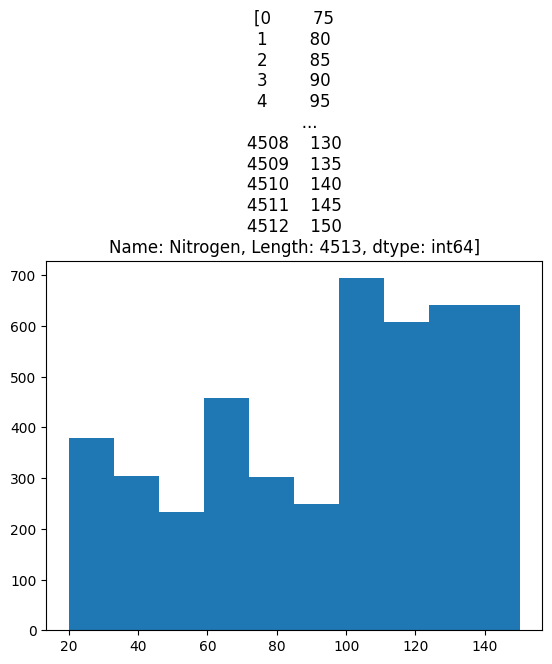

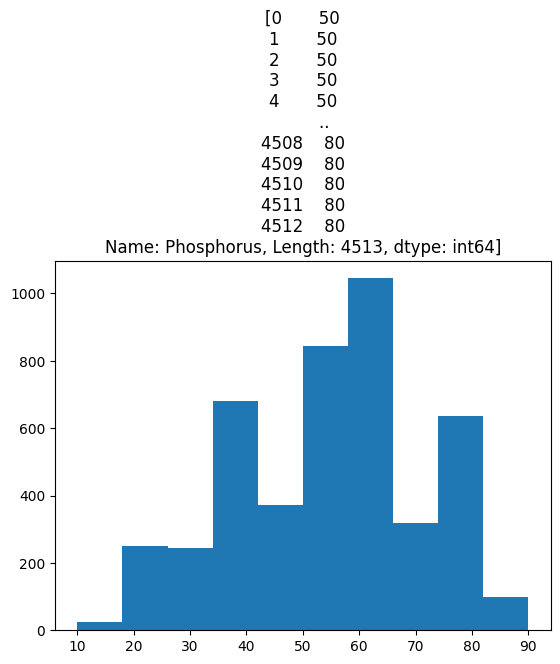

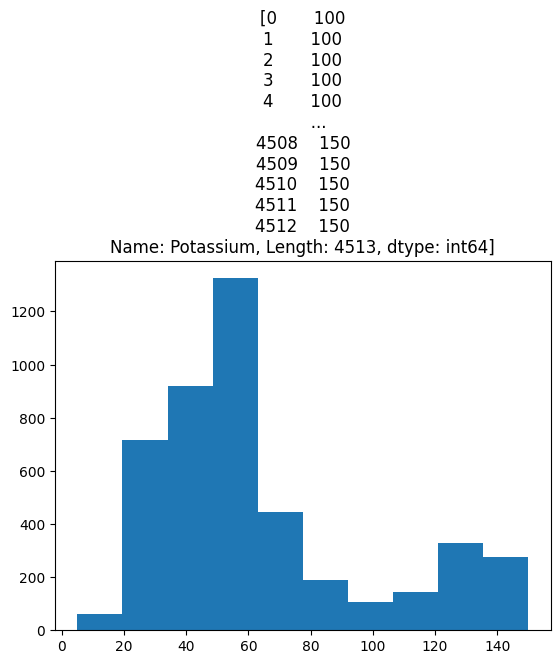

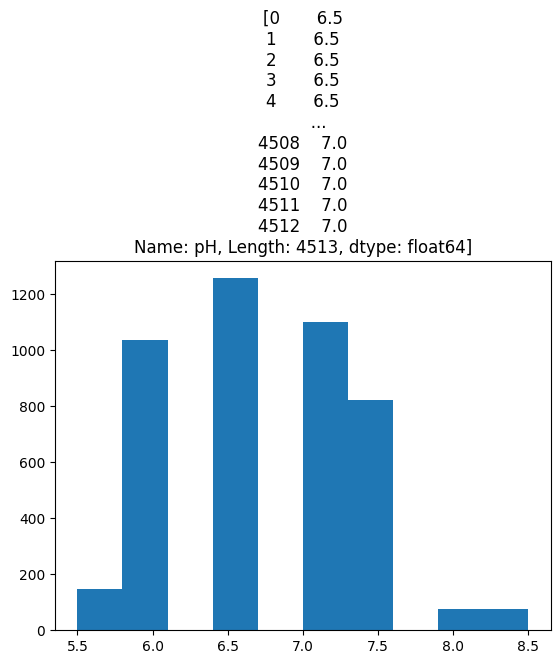

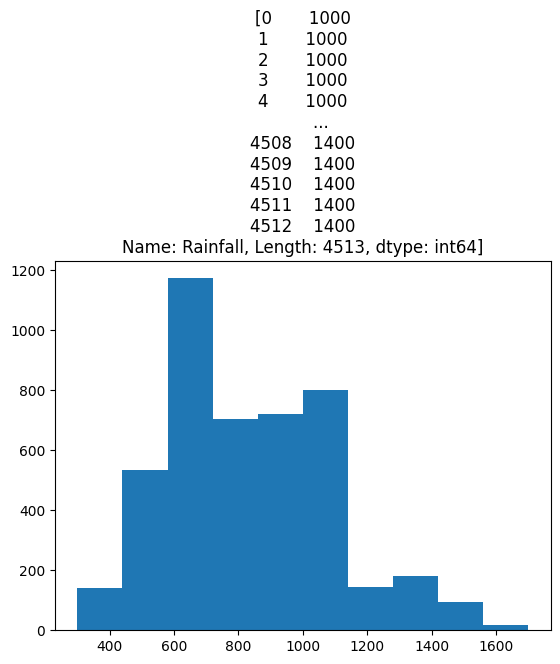

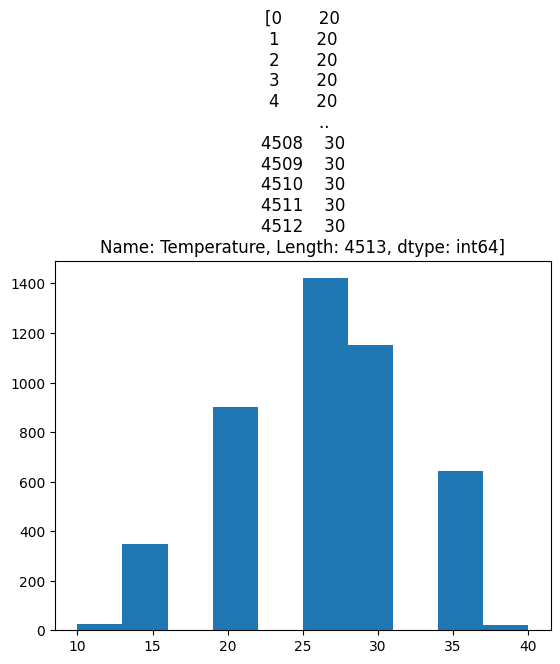

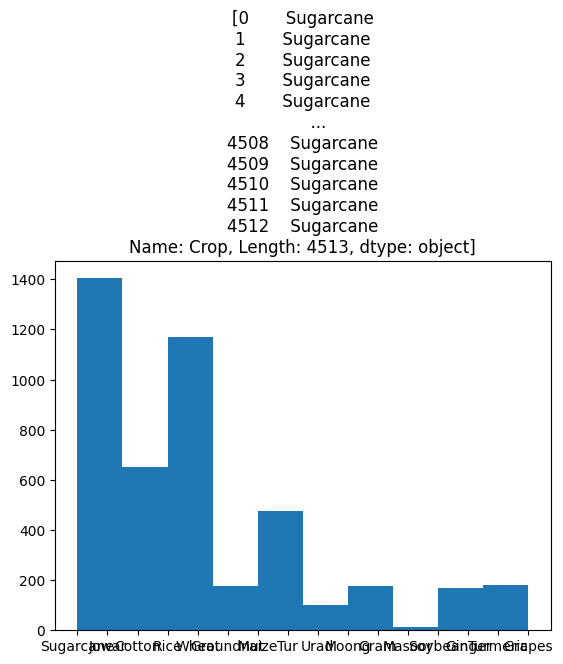

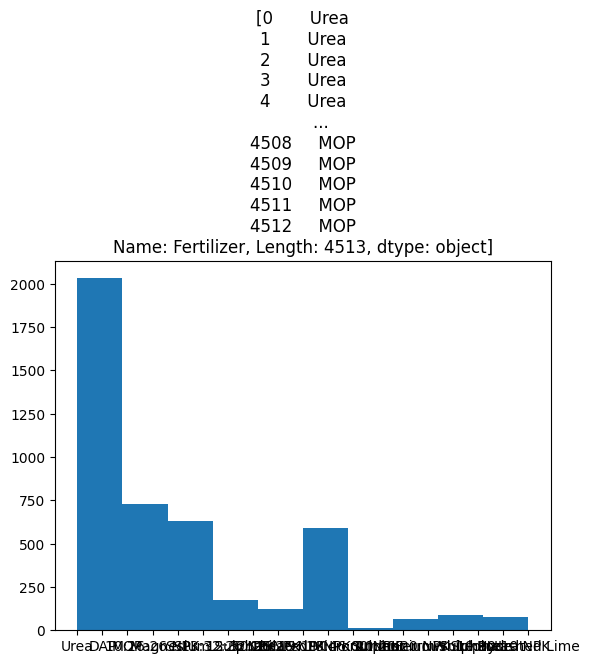

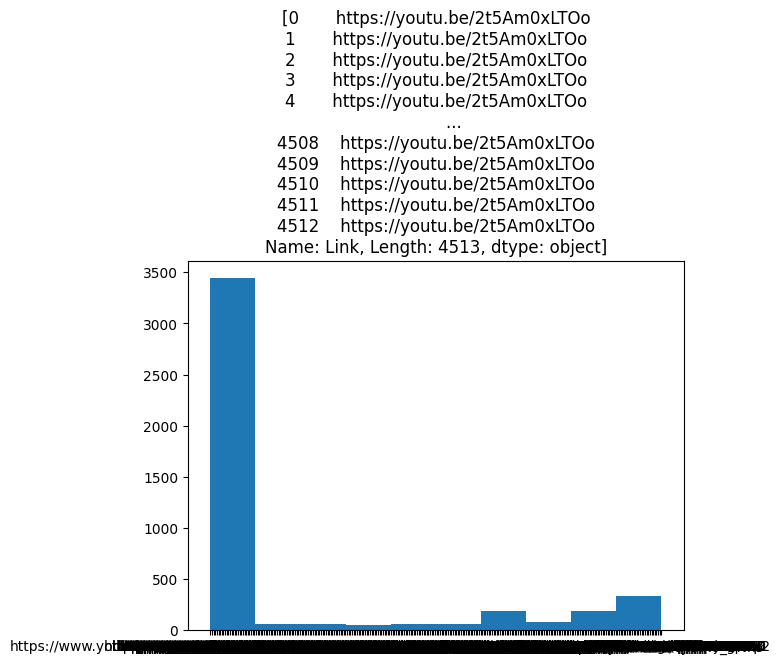

In [84]:
for i in dataset.columns:
    plt.hist(dataset[i])
    plt.title([dataset[i]])
    plt.show()

In [85]:
print (dataset.Soil_color.unique())
print (dataset.Soil_color.value_counts())

['Black' 'Red ' 'Medium Brown' 'Dark Brown' 'Red' 'Light Brown'
 'Reddish Brown']
Black            2260
Red               744
Dark Brown        659
Red               480
Reddish Brown     265
Light Brown        54
Medium Brown       51
Name: Soil_color, dtype: int64


<Axes: xlabel='District_Name', ylabel='count'>

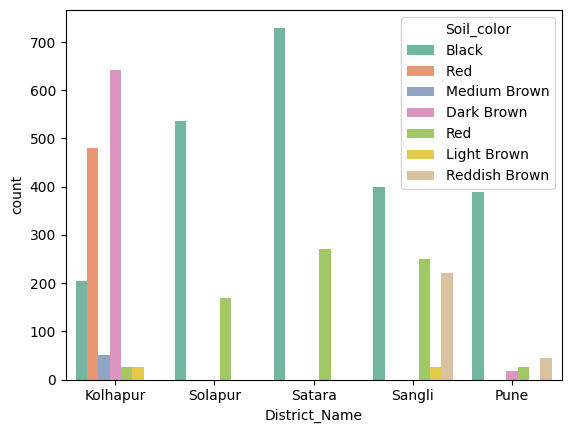

In [86]:
sns.countplot(dataset,x=dataset.District_Name,hue=dataset.Soil_color,palette='Set2')
#ok I can't spot a relationship excpet for gazira
#Sudan has a rich varity (different soil colors)

<Axes: xlabel='District_Name', ylabel='count'>

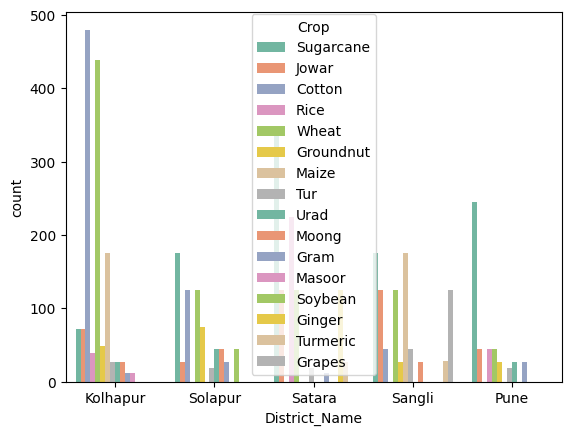

In [87]:
sns.countplot(dataset,x=dataset.District_Name,hue=dataset.Crop,palette='Set2')
# commulative somehow

In [88]:
dataset.columns.tolist()

['District_Name',
 'Soil_color',
 'Nitrogen',
 'Phosphorus',
 'Potassium',
 'pH',
 'Rainfall',
 'Temperature',
 'Crop',
 'Fertilizer',
 'Link']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Sugarcane'),
  Text(1, 0, 'Jowar'),
  Text(2, 0, 'Cotton'),
  Text(3, 0, 'Rice'),
  Text(4, 0, 'Wheat'),
  Text(5, 0, 'Groundnut'),
  Text(6, 0, 'Maize'),
  Text(7, 0, 'Tur'),
  Text(8, 0, 'Urad'),
  Text(9, 0, 'Moong'),
  Text(10, 0, 'Gram'),
  Text(11, 0, 'Masoor'),
  Text(12, 0, 'Soybean'),
  Text(13, 0, 'Ginger'),
  Text(14, 0, 'Turmeric'),
  Text(15, 0, 'Grapes')])

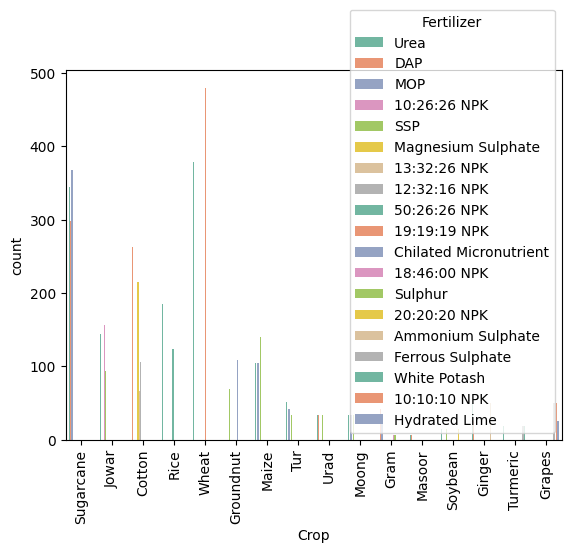

In [89]:
sns.countplot(dataset,x=dataset.Crop,hue=dataset.Fertilizer,palette='Set2')
plt.xticks(rotation=90)

Base-line Model

<ipython-input-90-9d3fd451b567>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(),annot=True)


<Axes: >

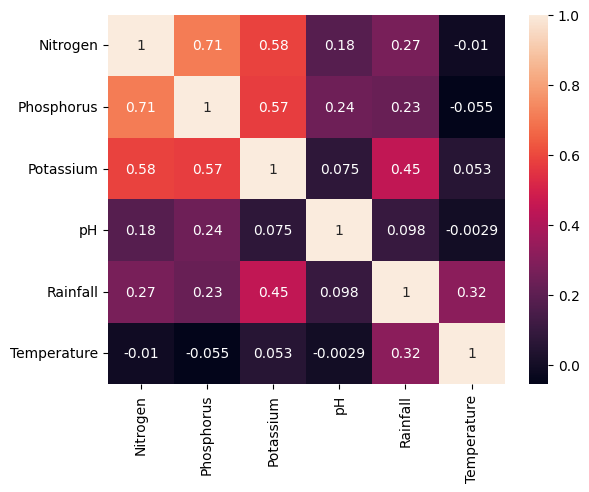

In [90]:
sns.heatmap(dataset.corr(),annot=True)

In [91]:
dataset.head(4)

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link
0,Kolhapur,Black,75,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
1,Kolhapur,Black,80,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
2,Kolhapur,Black,85,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
3,Kolhapur,Black,90,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo


# Feature Engineering Part

changing the names to match the sudanese culture charateristics and also generate more data to fix the issue of imbalanced 


In [92]:
new_data = pd.read_csv('/kaggle/input/crop-and-fertilizer-dataset-for-westernmaharashtra/Crop and fertilizer dataset.csv')
dataset = dataset.copy()
#change the district names into sudanese districts
mapping = {
     'Kolhapur': 'Khartoum',
    'Satara': 'Algazira',
    'Sangli': 'Shendi',
    'Solapur': 'ALfashir',
    'Pune': 'Niyala',
}


for original_value, new_name in mapping.items():
    dataset.loc[dataset['District_Name'] == original_value, 'District_Name'] = new_name


value_counts_with_new_names = dataset['District_Name'].value_counts()


print(value_counts_with_new_names)

mapping = {
     'Kolhapur': 'Khartoum',
    'Satara': 'Algazira',
    'Sangli': 'Shendi',
    'Solapur': 'ALfashir',
    'Pune': 'Niyala',
}


for original_value, new_name in mapping.items():
    new_data.loc[new_data['District_Name'] == original_value, 'District_Name'] = new_name


value_counts_with_new_names = new_data['District_Name'].value_counts()
print(value_counts_with_new_names)

dataset['Crop_string'] = new_data['Crop']
dataset['District_string'] = new_data['District_Name']
dataset['soil_string'] = new_data['Soil_color']

Khartoum    1430
Algazira    1000
Shendi       897
ALfashir     707
Niyala       479
Name: District_Name, dtype: int64
Khartoum    1430
Algazira    1000
Shendi       897
ALfashir     707
Niyala       479
Name: District_Name, dtype: int64


In [93]:
dataset.head(4)

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link,Crop_string,District_string,soil_string
0,Khartoum,Black,75,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
1,Khartoum,Black,80,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
2,Khartoum,Black,85,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
3,Khartoum,Black,90,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black


Label encoding


In [94]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset['District_Name'] = encoder.fit_transform(dataset['District_Name'])
dataset['Soil_color'] = encoder.fit_transform(dataset['Soil_color'])
dataset['Crop'] = encoder.fit_transform(dataset['Crop'])

original_to_encoded_mapping = {label: encoded_label for label, encoded_label in zip(encoder.classes_, encoder.transform(encoder.classes_))}
encoded_to_original_mapping = {encoded_label: label for label, encoded_label in zip(encoder.classes_, encoder.transform(encoder.classes_))}

dataset.head(9)

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link,Crop_string,District_string,soil_string
0,2,0,75,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
1,2,0,80,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
2,2,0,85,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
3,2,0,90,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
4,2,0,95,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
5,2,0,100,50,100,6.5,1000,20,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
6,2,0,75,55,105,7.0,1100,25,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
7,2,0,80,55,105,7.0,1100,25,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black
8,2,0,85,55,105,7.0,1100,25,11,Urea,https://youtu.be/2t5Am0xLTOo,Sugarcane,Khartoum,Black


Spliting 

In [95]:
from sklearn.model_selection import train_test_split
x = dataset.drop(columns=['Link','Fertilizer','Crop','District_string','Crop_string','soil_string'])
y = dataset['Crop']

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [96]:
print(original_to_encoded_mapping)

{'Cotton': 0, 'Ginger': 1, 'Gram': 2, 'Grapes': 3, 'Groundnut': 4, 'Jowar': 5, 'Maize': 6, 'Masoor': 7, 'Moong': 8, 'Rice': 9, 'Soybean': 10, 'Sugarcane': 11, 'Tur': 12, 'Turmeric': 13, 'Urad': 14, 'Wheat': 15}


In [97]:
print(y_train.shape)

(3610,)


# Synthetic Minority Over-sampling Technique
 is a popular method used to address class imbalance in datasets, particularly in the context of machine learning and classification tasks. It is specifically designed to tackle the issue of imbalanced datasets by oversampling the minority class, thereby alleviating the bias towards the majority class.

it was our winning card to solve the overfitting problem we faced
as the keras model is considered powerful

In [98]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

X = dataset.drop(columns=['Crop','Fertilizer','Link','Crop_string','District_string','soil_string'])  # Features
y = dataset['Crop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [99]:
X_train_resampled.shape

(12880, 8)

In [100]:
x_train.shape

(3610, 8)

In [101]:
dataset[['District_Name','District_string']]

,District_Name,District_string
0,2,Khartoum
1,2,Khartoum
2,2,Khartoum
3,2,Khartoum
4,2,Khartoum
...,...,...
4508,3,Niyala
4509,3,Niyala
4510,3,Niyala
4511,3,Niyala


In [102]:
"""import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


X = dataset.drop(columns=['Link','Fertilizer','Crop','District_string','Crop_string','soil_string'], axis=1)
Y = dataset['Crop']

#Encode the target labels #why? our model is doing better with numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the features (it's like the statistical normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(x_test)"""


"import tensorflow as tf\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder, StandardScaler\n\n\nX = dataset.drop(columns=['Link','Fertilizer','Crop','District_string','Crop_string','soil_string'], axis=1)\nY = dataset['Crop']\n\n#Encode the target labels #why? our model is doing better with numbers\nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y)\n\n#Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)\n\n# Standardize the features (it's like the statistical normalization)\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train_resampled)\nX_test_scaled = scaler.transform(x_test)"

# Saving the Encoder and the Scaler

In [103]:
"""import pickle

# Save LabelEncoder
encoder_path = "/content/encoderfinal.pkl"
with open(encoder_path, "wb") as f:
    pickle.dump(encoder, f)

# Save StandardScaler
scaler_path = "/content/scalerfinal.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
"""

'import pickle\n\n# Save LabelEncoder\nencoder_path = "/content/encoderfinal.pkl"\nwith open(encoder_path, "wb") as f:\n    pickle.dump(encoder, f)\n\n# Save StandardScaler\nscaler_path = "/content/scalerfinal.pkl"\nwith open(scaler_path, "wb") as f:\n    pickle.dump(scaler, f)\n'

In [104]:
x_train.shape

(3610, 8)

# Reem Part Base line models to check the nature of our data
## **so** **i** **will** **create** **instances** **of** **all** **models**

In [105]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()

X_train = ms.fit_transform(x_train)
X_test = ms.transform(x_test)

In [106]:
x_train

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature
3903,4,0,25,25,50,6.0,1600,25
999,2,1,85,55,40,6.5,800,15
2366,1,4,85,50,45,7.0,1400,30
1474,0,0,120,75,80,8.5,500,25
3859,4,4,70,60,45,6.0,800,25
...,...,...,...,...,...,...,...,...
4426,3,0,140,70,125,7.0,1400,30
466,2,5,115,60,75,7.5,1000,35
3092,1,0,60,45,60,6.0,600,20
3772,4,4,60,50,55,7.5,900,30


In [107]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


sc.fit(x_train)
x_train = sc.transform(x_train)
X_test = sc.transform(x_test)

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# create instances of all models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extra Trees': ExtraTreeClassifier(),
}


for name, md in models.items():
    md.fit(x_train,y_train)
    ypred = md.predict(x_test)

    print(f"{name}  with accuracy : {accuracy_score(y_test,ypred)}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Logistic Regression  with accuracy : 0.23920265780730898
Naive Bayes  with accuracy : 0.016611295681063124


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Support Vector Machine  with accuracy : 0.22702104097452935
K-Nearest Neighbors  with accuracy : 0.16611295681063123
Decision Tree  with accuracy : 0.22702104097452935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


Random Forest  with accuracy : 0.22702104097452935
Bagging  with accuracy : 0.22702104097452935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


AdaBoost  with accuracy : 0.22702104097452935
Gradient Boosting  with accuracy : 0.22702104097452935
Extra Trees  with accuracy : 0.22702104097452935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(


In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(x_train,y_train)  #this line of code, is the training,
predicted = dt_classifier.predict(x_test)
score = accuracy_score(y_test,predicted)
print (score)

0.22702104097452935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = RandomForestClassifier()
dt_classifier.fit(x_train,y_train)
predicted = dt_classifier.predict(x_test)
score = accuracy_score(y_test,predicted)
print (score)

0.22702104097452935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [111]:
new_data = pd.read_csv('/kaggle/input/crop-and-fertilizer-dataset-for-westernmaharashtra/Crop and fertilizer dataset.csv')
new_data['predicted_label'] = encoder.fit_transform(dataset['Crop'])

In [112]:
array = np.array([[2.0,   5.0 , 110.0 ,  55.0 ,  65.0 ,   7.5, 800.0 ,  25.0 ]])

In [113]:
dataset['Link']
array2 = np.array([[  0.0 ,   4.0 ,  60.0 ,  40.0 ,  55.0 ,   7.5, 600.0 ,  30.0 ]])

In [114]:
predicted_label = encoder.inverse_transform(predicted)

# Save the Data

In [115]:
#dataset.to_csv('the_data.csv')

# TensorFLow
we will be using tensorflow to build a neural network (deep learning algorithm)
1. the baseline keras model
2. fine tuned model


In [116]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


X = dataset.drop(columns=['Link','Fertilizer','Crop','District_string','Crop_string','soil_string'], axis=1)
Y = dataset['Crop']

# Encode the target labels #why? our model is doing better with numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the features (it's like the statistical normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(x_test)

# we are building our neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer with 16 units for 16 crop types
])

# Compile the model
"""model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])"""

# Train the model
"""history = model.fit(X_train_scaled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)"""

"""# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print('Test Accuracy:', test_accuracy)
"""""

"# Evaluate the model\ntest_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)\nprint('Test Accuracy:', test_accuracy)\n"

In [117]:
"""import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
"""

"import matplotlib.pyplot as plt\n\n# Plot training & validation accuracy values\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()\n\n# Plot training & validation loss values\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()\n"

1. Training Accuracy: 99.65%
2. Validation Accuracy: 99.86%
3. Test Accuracy: 99.67%

since the validation accuracy is slightly higher than the training accuracy, it might indicate that your model could still benefit from more training data or regularization techniques to prevent overfitting.



In [118]:
"""import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Regularized model with L2 kernel regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print('Test Accuracy:', test_accuracy)"""

"import tensorflow as tf\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder, StandardScaler\n\n\n# Regularized model with L2 kernel regularization\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03), input_shape=(X_train_scaled.shape[1],)),\n    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)),\n    tf.keras.layers.Dense(16, activation='softmax')  # Output layer\n])\n\n# Compile the model\nmodel.compile(optimizer='adam',\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n\nhistory = model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2)\ntest_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)\nprint('Test Accuracy:', test_accuracy)"

In [119]:
"""import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Regularized model with L2 kernel regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.024), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.024)),
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_resampled, epochs=400, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print('Test Accuracy:', test_accuracy)"""

"import tensorflow as tf\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder, StandardScaler\n\n\n# Regularized model with L2 kernel regularization\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.024), input_shape=(X_train_scaled.shape[1],)),\n    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.024)),\n    tf.keras.layers.Dense(16, activation='softmax')  # Output layer\n])\n\n# Compile the model\nmodel.compile(optimizer='adam',\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n\nhistory = model.fit(X_train_scaled, y_train_resampled, epochs=400, batch_size=32, validation_split=0.2)\ntest_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)\nprint('Test Accuracy:', test_accuracy)"

In [120]:
"""import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()"""


"import matplotlib.pyplot as plt\n\n# Plot training & validation accuracy values\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()\n\n# Plot training & validation loss values\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()"

# Our Winning Model So far
applied regualization
and a learning rate, and 400 epochs

In [121]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Regularized model with L2 kernel regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0099), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0099)),
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_resampled, epochs=400, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print('Test Accuracy:', test_accuracy)

Epoch 1/400
322/322 [==============================] - 2s 3ms/step - loss: 1.7967 - accuracy: 0.6153 - val_loss: 4.0349 - val_accuracy: 0.1328
Epoch 2/400
322/322 [==============================] - 1s 3ms/step - loss: 0.9739 - accuracy: 0.8436 - val_loss: 3.1968 - val_accuracy: 0.1374
Epoch 3/400
322/322 [==============================] - 1s 3ms/step - loss: 0.7975 - accuracy: 0.8912 - val_loss: 2.4336 - val_accuracy: 0.3168
Epoch 4/400
322/322 [==============================] - 1s 3ms/step - loss: 0.6954 - accuracy: 0.9180 - val_loss: 2.1668 - val_accuracy: 0.4348
Epoch 5/400
322/322 [==============================] - 1s 3ms/step - loss: 0.6271 - accuracy: 0.9337 - val_loss: 2.0075 - val_accuracy: 0.4515
Epoch 6/400
322/322 [==============================] - 1s 3ms/step - loss: 0.5752 - accuracy: 0.9455 - val_loss: 1.9380 - val_accuracy: 0.4515
Epoch 7/400
322/322 [==============================] - 1s 3ms/step - loss: 0.5367 - accuracy: 0.9486 - val_loss: 1.7143 - val_accuracy: 0.4604

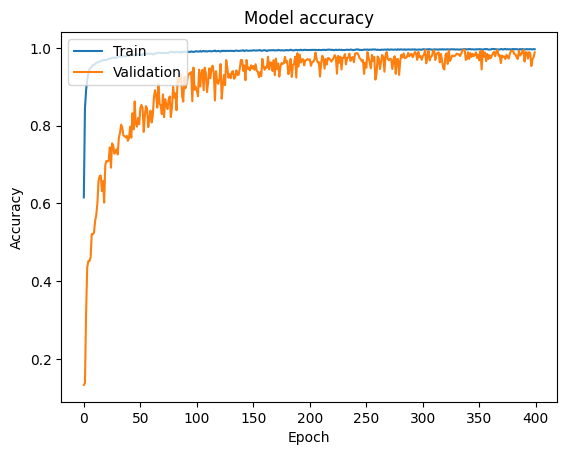

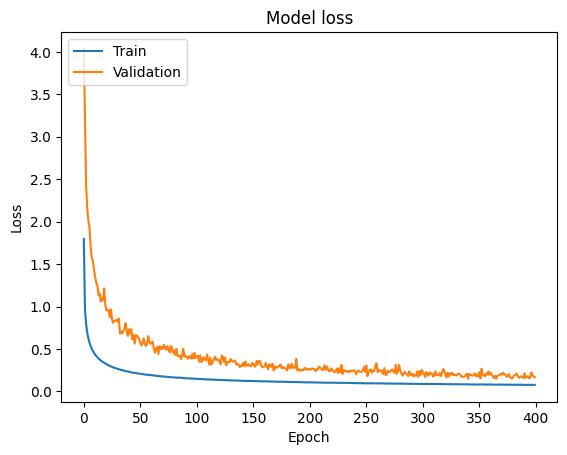

In [122]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# A Lovely Function 🤓✨

do you remember our encoding map? the map each element with a corrsponding string value? so I try to use it here, but I found difficulties so I used the dic stored in original_to_encoded_mapping

In [124]:
original_to_encoded_mapping

{'Cotton': 0,
 'Ginger': 1,
 'Gram': 2,
 'Grapes': 3,
 'Groundnut': 4,
 'Jowar': 5,
 'Maize': 6,
 'Masoor': 7,
 'Moong': 8,
 'Rice': 9,
 'Soybean': 10,
 'Sugarcane': 11,
 'Tur': 12,
 'Turmeric': 13,
 'Urad': 14,
 'Wheat': 15}

In [125]:
def predict_crop(new_values):
    # Standardize the new values using the same scaler
    new_values_scaled = scaler.transform(new_values)
    predictions = model.predict(new_values_scaled)
    predicted_class_index = predictions.argmax(axis=1)
    predicted_crop_class = encoder.inverse_transform(predicted_class_index)


    encoded_to_label = {
    0: 'Cotton',
    1: 'Ginger',
    2: 'Gram',
    3: 'Grapes',
    4: 'Groundnut',
    5: 'Jowar',
    6: 'Maize',
    7: 'Masoor',
    8: 'Moong',
    9: 'Rice',
    10: 'Soybean',
    11: 'Sugarcane',
    12: 'Tur',
    13: 'Turmeric',
    14: 'Urad',
    15: 'Wheat'}

    def decode_label(encoded_value):
      return encoded_to_label.get(encoded_value, "Label not found")

    encoded_value = int(predicted_class_index)
    decoded_label = decode_label(encoded_value)
    #("Decoded label:", decoded_label)


    return encoded_to_label.get(encoded_value, "Label not found")

In [126]:
predict_crop(array) # great so our function now works

1/1 [==============================] - 0s 116ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Cotton'

In [127]:
def corrsponding_youtube_tutorial(x):
    predicted = dt_classifier.predict(x)
    predicted_label = encoder.inverse_transform(predicted)
    link = new_data.loc[dataset['Crop'] == predicted_label[0], 'Link'].values[0]

    return predicted_label, link

In [ ]:
corrsponding_youtube_tutorial(array)

# Filtering Method
usually machine learning doesn't involve this kind of analysis, or tool
but here is another lovely function that takes
1. the city you live in
2. the available fertilizer you have
3. and your soil color
and return to you what are the best possible crops to grow.
##so Challenges are
1. if these features will be in the same interface but optional marking
2. or a new different window!

In [128]:
import pandas as pd

def predict_possible_crops( district, fertilizer, soil):
    # Filter the dataset based on the provided parameters
    filtered_data = dataset[(dataset['District_string'] == district) &
                            (dataset['Fertilizer'] == fertilizer) &
                            (dataset['soil_string'] == soil)]

    # Extract the unique crop names from the filtered data
    possible_crops = filtered_data['Crop_string'].unique().tolist()

    return "Possible crops:", possible_crops

# Example usage:
district = 'Khartoum'
fertilizer = 'Urea'
soil = 'Black'

possible_crops = predict_possible_crops( district, fertilizer, soil)
print("Possible crops:", possible_crops)


Possible crops: ('Possible crops:', ['Sugarcane', 'Jowar'])


In [129]:
predict_possible_crops('Shendi','Urea','Red') #user friendly #this is not prediction

('Possible crops:', ['Jowar'])

In [130]:
district = 'Khartoum'
soil_color = 'Black'
nitrogen = 75
phosphorus = 50
potassium = 100
ph = 6.5
rainfall = 100
temperature = 20

encoded_district = encoder.fit_transform([district])[0]
encoded_soil_color = encoder.fit_transform([soil_color])[0]

features = scaler.transform([[encoded_district,encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]])
prediction = model.predict(features)
predicted_class_index = prediction.argmax(axis=1)[0]
predicted_class_index

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0

In [131]:
def predict_crop_s(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature):
    encoded_district = encoder.fit_transform([district])[0]
    encoded_soil_color = encoder.fit_transform([soil_color])[0]

    features = scaler.transform([[encoded_district,encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]])
    prediction = model.predict(features)
    predicted_class_index = prediction.argmax(axis=1)[0]
    #predicted_crop = encoder.inverse_transform([predicted_class_index])[0]


    return predicted_class_index


def decode_label(encoded_value):
  return encoded_to_label.get(encoded_value, "Label not found")



encoded_to_label = {
0: 'Cotton',
1: 'Ginger',
    2: 'Gram',
    3: 'Grapes',
    4: 'Groundnut',
    5: 'Jowar',
    6: 'Maize',
    7: 'Masoor',
    8: 'Moong',
    9: 'Rice',
    10: 'Soybean',
    11: 'Sugarcane',
    12: 'Tur',
    13: 'Turmeric',
    14: 'Urad',
    15: 'Wheat'}



# Example:
district = 'Khartoum'
soil_color = 'Black'
nitrogen = 75
phosphorus = 50
potassium = 100
ph = 6.5
rainfall = 100
temperature = 20

crop = predict_crop_s(district,soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)
label = decode_label(crop)
print("Predicted Crop:", label)

1/1 [==============================] - 0s 23ms/step
Predicted Crop: Cotton


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [132]:
#dataset[['District_Name','District_string']]
dataset.loc[dataset['District_Name'] == 1]

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link,Crop_string,District_string,soil_string
2137,1,4,50,30,20,6.0,600,25,12,Urea,https://youtu.be/WaWgxSZHiWo,Tur,Algazira,Red
2138,1,4,55,30,20,6.0,600,25,12,Urea,https://youtu.be/WaWgxSZHiWo,Tur,Algazira,Red
2139,1,4,60,30,20,6.0,600,25,12,Urea,https://youtu.be/WaWgxSZHiWo,Tur,Algazira,Red
2140,1,4,50,35,25,6.5,700,30,12,Urea,https://youtu.be/WaWgxSZHiWo,Tur,Algazira,Red
2141,1,4,55,35,25,6.5,700,30,12,Urea,https://youtu.be/WaWgxSZHiWo,Tur,Algazira,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,1,0,60,60,55,6.0,500,15,15,19:19:19 NPK,https://youtu.be/VNptnPJt5yo,Wheat,Algazira,Black
3133,1,0,65,60,55,6.0,500,15,15,19:19:19 NPK,https://youtu.be/VNptnPJt5yo,Wheat,Algazira,Black
3134,1,0,70,60,55,6.0,500,15,15,19:19:19 NPK,https://youtu.be/VNptnPJt5yo,Wheat,Algazira,Black
3135,1,0,75,60,55,6.0,500,15,15,19:19:19 NPK,https://youtu.be/VNptnPJt5yo,Wheat,Algazira,Black


List of my Functions:
1. corrsponding_youtube_tutorial
it gives you a YouTube tutorial to watch, based on your suggested crop!
2. predict_possible_crops
returns the possible crops to grow, based on your city! soil color and available fertilizer

In [133]:
x_test.iloc[12]

District_Name      1.0
Soil_color         0.0
Nitrogen          50.0
Phosphorus        50.0
Potassium         80.0
pH                 5.5
Rainfall         900.0
Temperature       20.0
Name: 2922, dtype: float64

In [134]:
y_test.iloc[12]

1

In [135]:
district = 'Algazira'
soil_color = 'Black'
nitrogen = 55
phosphorus = 45
potassium = 88
ph = 5.0
rainfall = 900
temperature = 22

crop = predict_crop_s(district,soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)
label = decode_label(crop)
print("Predicted Crop:", label)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step
Predicted Crop: Ginger


#Indeed we give the model the same values but we teakles it! and it returns the ginger!

In [136]:
#dataset.to_csv('crop_and_fertilizer.csv')

In [137]:
#X_train_resampled.to_csv('x_train_resampled.csv')
#y_train_resampled.to_csv('y_train_resampled.csv')

# Load and save the Model

we need to save the model

In [138]:
"""model_path = "my_model.h5"
model.save(model_path)"""

'model_path = "my_model.h5"\nmodel.save(model_path)'

In [139]:
"""from tensorflow.keras.models import load_model
loaded_model = load_model(model_path)"""

'from tensorflow.keras.models import load_model\nloaded_model = load_model(model_path)'

In [140]:
"""import joblib

joblib.dump(encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')"""

"import joblib\n\njoblib.dump(encoder, 'label_encoder.pkl')\njoblib.dump(scaler, 'scaler.pkl')"

In [141]:
"""import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)"""

"import pickle\n\nwith open('model.pkl', 'wb') as f:\n    pickle.dump(model, f)"

In [153]:
encoded_to_label = {
    0: 'Cotton',
    1: 'Ginger',
    2: 'Gram',
    3: 'Grapes',
    4: 'Groundnut',
    5: 'Jowar',
    6: 'Maize',
    7: 'Masoor',
    8: 'Moong',
    9: 'Rice',
    10: 'Soybean',
    11: 'Sugarcane',
    12: 'Tur',
    13: 'Turmeric',
    14: 'Urad',
    15: 'Wheat'
}

def decode_label(encoded_value):
    return encoded_to_label.get(encoded_value, "Label not found")


In [154]:
def predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature):
    # Encode categorical variables
    try:
        # Encode categorical variables
        encoded_district = encoder.fit_transform([district])[0]
        encoded_soil_color = encoder.fit_transform([soil_color])[0]

        # Scale numerical features
        features = [[encoded_district, encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]]
        scaled_features = scaler.transform(features)

        # Make prediction
        prediction = model.predict(scaled_features)
        predicted_class_index = np.argmax(prediction)

        # Decode predicted class
        predicted_crop = decode_label(predicted_class_index)
        return predicted_crop,scaled_features
    except Exception as e:
        print(f"Error: {e}")
        return "Error occurred during prediction"


In [155]:
district = 'Algazira'
soil_color = 'Black'
nitrogen = 55
phosphorus = 45
potassium = 88
ph = 5.0
rainfall = 900
temperature = 22
array = np.array([district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature])
result = predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)

print('Recommended Crop:', result,array)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 35ms/step
Recommended Crop: ('Ginger', array([[-1.33414184, -0.83215698, -0.35507048,  0.03048284,  1.20534696,
        -2.7664979 ,  0.48494069, -0.80581642]])) ['Algazira' 'Black' '55' '45' '88' '5.0' '900' '22']


In [156]:
def predict_crop_s(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature):
    encoded_district = encoder.fit_transform([district])[0]
    encoded_soil_color = encoder.fit_transform([soil_color])[0]

    features = scaler.transform([[encoded_district,encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]])
    prediction = model.predict(features)
    predicted_class_index = prediction.argmax(axis=1)[0]
    #predicted_crop = encoder.inverse_transform([predicted_class_index])[0]


    return predicted_class_index


def decode_label(encoded_value):
  return encoded_to_label.get(encoded_value, "Label not found")



encoded_to_label = {
0: 'Cotton',
1: 'Ginger',
    2: 'Gram',
    3: 'Grapes',
    4: 'Groundnut',
    5: 'Jowar',
    6: 'Maize',
    7: 'Masoor',
    8: 'Moong',
    9: 'Rice',
    10: 'Soybean',
    11: 'Sugarcane',
    12: 'Tur',
    13: 'Turmeric',
    14: 'Urad',
    15: 'Wheat'}



# Example:
district = 'Khartoum'
soil_color = 'Black'
nitrogen = 75
phosphorus = 50
potassium = 100
ph = 6.5
rainfall = 100
temperature = 20

crop = predict_crop_s(district,soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)
label = decode_label(crop)
print("Predicted Crop:", label)

1/1 [==============================] - 0s 63ms/step
Predicted Crop: Cotton


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [157]:
seri = pd.DataFrame(dataset['District_string'].unique())
seri['encoded'] = encoder.fit_transform(seri)
new = pd.DataFrame(dataset['Soil_color'].unique())
new['encoded_soil'] = encoder.fit_transform(new)

x = dataset[['District_Name','Soil_color','Nitrogen','Phosphorus','Potassium','pH','Rainfall','Temperature']]
transformed = scaler.fit_transform(x)

encoded_to_label = {
    0: 'Cotton',
    1: 'Ginger',
    2: 'Gram',
    3: 'Grapes',
    4: 'Groundnut',
    5: 'Jowar',
    6: 'Maize',
    7: 'Masoor',
    8: 'Moong',
    9: 'Rice',
    10: 'Soybean',
    11: 'Sugarcane',
    12: 'Tur',
    13: 'Turmeric',
    14: 'Urad',
    15: 'Wheat'
}

def decode_label(encoded_value):
    return encoded_to_label.get(encoded_value, "Label not found")

def predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature):

    try:
        encoded_district = encoder.fit_transform([district])[0]
        encoded_soil_color = encoder.fit_transform([soil_color])[0]

        features = [[encoded_district, encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]]
        scaled_features = scaler.fit_transform(features)


        prediction = model.predict(scaled_features)
        predicted_class_index = np.argmax(prediction)


        predicted_crop = decode_label(predicted_class_index)
        return predicted_crop,encoded_district
    except Exception as e:
        print(f"Error: {e}")
        return "Error occurred during prediction"
    prediction = model.predict(features)
    predicted_class_index = np.argmax(prediction)

    predicted_crop = decode_label(predicted_class_index)
    return predicted_crop



result = predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)

print('Recommended Crop:', result)

1/1 [==============================] - 0s 40ms/step
Recommended Crop: ('Wheat', 0)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [158]:
district_to_encoded = {
    'Khartoum': 2,
    'ALfashir': 0,
    'Algazira': 1,
    'Shendi': 4,
    'Niyala': 3

}
soil_color_to_encoded = {
    'Black': 0,
    'Red': 5,
    'Medium Brown': 3,
    'Dark Brown': 1,
    'Light Brown': 2,
    'Reddish Brown': 6

}

def predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature):
    try:

        encoded_district = district_to_encoded.get(district, -1)


        if encoded_district == -1:
            return "Invalid district", None


        encoded_soil_color = soil_color_to_encoded.get(soil_color, -1)


        if encoded_soil_color == -1:
            return "Invalid soil color", None


        features = [[encoded_district, encoded_soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature]]
        scaled_features = scaler.transform(features)


        prediction = model.predict(scaled_features)
        predicted_class_index = np.argmax(prediction)


        predicted_crop = decode_label(predicted_class_index)
        return predicted_crop, encoded_district
    except Exception as e:
        print(f"Error: {e}")
        return "Error occurred during prediction", None


district = 'Algazira'
soil_color = 'Black'
nitrogen = 55
phosphorus = 45
potassium = 88
ph = 5.0
rainfall = 900
temperature = 22

result, encoded_district = predict(district, soil_color, nitrogen, phosphorus, potassium, ph, rainfall, temperature)
print('Recommended Crop:', result)
print('Encoded District:', encoded_district)


1/1 [==============================] - 0s 38ms/step
Recommended Crop: Sugarcane
Encoded District: 1
